# Starbucks offers: Advanced customer segmentation with Python
_This is a Udacity Data Science Nanodegree Capstone project._

## Dataset

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

# Libraries

In [36]:
# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Basic libraries
#
import pandas as pd
import numpy as np
import math
import json
# import datetime

# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Visualization libraries
#
import seaborn as sns
import matplotlib.pyplot as plt
# import plotly.express as px

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
# from sklearn.neighbors import NearestNeighbors
# from sklearn.preprocessing import LabelEncoder
# from sklearn import metrics


from lifetimes.utils import summary_data_from_transaction_data

# Import Data

In [2]:
# Load JSON files
portfolio  = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile    = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Pre-process data

In [3]:
# convert dates to Datetime
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')

# fill empty genders
profile['gender'] = profile['gender'].fillna('NA')

### Impute income

In [4]:
profile['income_na'] = profile['income'].isna().astype(int)
profile['income'] = profile['income'].fillna(profile['income'].mean())

### One-hot encoding

In [5]:
# channel dummies
mlb = MultiLabelBinarizer()
channel_dummies = pd.DataFrame(mlb.fit_transform(portfolio['channels']), columns=mlb.classes_, index=portfolio.index)

# offer type dummies
offer_type_dummies = portfolio['offer_type'].str.get_dummies()

portfolio = pd.concat([portfolio, channel_dummies, offer_type_dummies], axis=1)

#portfolio.drop(['channels', 'offer_type'], axis=1, inplace=True)

portfolio.head( 3 )

,reward,channels,difficulty,duration,offer_type,id,email,mobile,social,web,bogo,discount,informational
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,1,0,0
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1,0,0,1


In [6]:
# gender type dummies
profile['year_joined'] = profile['became_member_on'].apply(lambda x: str(x.year))

gender_dummies      = profile['gender'].str.get_dummies().add_prefix('gender_')
year_joined_dummies = profile['year_joined'].str.get_dummies().add_prefix('year_joined_')

profile = pd.concat([profile, gender_dummies, year_joined_dummies], axis=1)

#profile.drop(['gender'], axis=1, inplace=True)
profile.drop(['became_member_on'], axis=1, inplace=True)
profile.drop(['year_joined'], axis=1, inplace=True)

profile.head( 3 )

,gender,age,id,income,income_na,gender_F,gender_M,gender_NA,gender_O,year_joined_2013,year_joined_2014,year_joined_2015,year_joined_2016,year_joined_2017,year_joined_2018
0,NA,118,68be06ca386d4c31939f3a4f0e3dd783,65404.991568,1,0,0,1,0,0,0,0,0,1,0
1,F,55,0610b486422d4921ae7d2bf64640c50b,112000.000000,0,1,0,0,0,0,0,0,0,1,0
2,NA,118,38fe809add3b4fcf9315a9694bb96ff5,65404.991568,1,0,0,1,0,0,0,0,0,0,1


In [7]:
# event dummies
event_dummies = transcript['event'].str.get_dummies()
event_dummies.drop('transaction', axis=1, inplace=True)

transcript = pd.concat([transcript, event_dummies], axis=1)
transcript.rename(columns={'offer completed': 'offer_completed', 'offer received': 'offer_received', 'offer viewed': 'offer_viewed'}, inplace=True)

#profile.drop(['event'], axis=1, inplace=True)

transcript.head( 3 )

,person,event,value,time,offer_completed,offer_received,offer_viewed
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,0,1,0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0,1,0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,0,1,0


### Split offer and transaction dataframes


In [8]:
transactions = transcript.query('event == "transaction"').copy()
transactions['amount'] = transactions['value'].apply(lambda x: list(x.values())[0])
transactions.drop(['value', 'offer_completed', 'offer_received', 'offer_viewed'], axis=1, inplace=True)

offers = transcript.query('event != "transaction"').copy()
offers['offer_id'] = offers['value'].apply(lambda x: list(x.values())[0])
offers.drop(['value'], axis=1, inplace=True)

### Merge dataframes

In [9]:
offers = offers.merge(profile, left_on='person', right_on='id')
offers = offers.merge(portfolio, left_on='offer_id', right_on='id')
offers.drop(['id_x', 'id_y'], axis=1, inplace=True)
offers.set_index('offer_id', inplace=True)
offers.head(2)

,person,event,time,offer_completed,offer_received,offer_viewed,gender,age,income,income_na,...,difficulty,duration,offer_type,email,mobile,social,web,bogo,discount,informational
offer_id,,,,,,,,,,,,,,,,,,,,,
9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,0,1,0,F,75,100000.0,0,...,5,7,bogo,1,1,0,1,1,0,0
9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,6,0,0,1,F,75,100000.0,0,...,5,7,bogo,1,1,0,1,1,0,0


In [10]:
transactions = transactions.merge(profile, left_on='person', right_on='id')
transactions.drop(['event'], axis=1, inplace=True)
transactions.head(2)

,person,time,amount,gender,age,id,income,income_na,gender_F,gender_M,gender_NA,gender_O,year_joined_2013,year_joined_2014,year_joined_2015,year_joined_2016,year_joined_2017,year_joined_2018
0,02c083884c7d45b39cc68e1314fec56c,0,0.83,F,20,02c083884c7d45b39cc68e1314fec56c,30000.0,0,1,0,0,0,0,0,0,1,0,0
1,02c083884c7d45b39cc68e1314fec56c,6,1.44,F,20,02c083884c7d45b39cc68e1314fec56c,30000.0,0,1,0,0,0,0,0,0,1,0,0


### Drop outliers

In [11]:
profile = profile.query('age <= 99')
offers = offers.query('age <= 99')
transactions = transactions.query('age <= 99')

### Repeat offer exposure

In [12]:
offers.reset_index(inplace=True)

In [13]:
# the same offer can be received and viewed multiple times
offers[offers.duplicated(subset=['offer_id', 'person'], keep=False)].head( 3 )

,offer_id,person,event,time,offer_completed,offer_received,offer_viewed,gender,age,income,...,difficulty,duration,offer_type,email,mobile,social,web,bogo,discount,informational
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,0,1,0,F,75,100000.0,...,5,7,bogo,1,1,0,1,1,0,0
1,9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,6,0,0,1,F,75,100000.0,...,5,7,bogo,1,1,0,1,1,0,0
2,9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef,offer completed,132,1,0,0,F,75,100000.0,...,5,7,bogo,1,1,0,1,1,0,0


In [14]:
# add receipt, view and completion time columns
offers['time'] = offers['time'] + 0.5
offers['received_time'] = offers['offer_received'] * offers['time']
offers['viewed_time'] = offers['offer_viewed'] * offers['time']
offers['completed_time'] = offers['offer_completed'] * offers['time']

offers.head( 3 )

,offer_id,person,event,time,offer_completed,offer_received,offer_viewed,gender,age,income,...,email,mobile,social,web,bogo,discount,informational,received_time,viewed_time,completed_time
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef,offer received,0.5,0,1,0,F,75,100000.0,...,1,1,0,1,1,0,0,0.5,0.0,0.0
1,9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,6.5,0,0,1,F,75,100000.0,...,1,1,0,1,1,0,0,0.0,6.5,0.0
2,9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef,offer completed,132.5,1,0,0,F,75,100000.0,...,1,1,0,1,1,0,0,0.0,0.0,132.5


In [15]:
# an offer can be received multiple times by the same person
# we'll use first exposure times, but keep track of the number of exposures

offers_mins = offers.groupby(['person', 'offer_id', 'event']).min()
offers_sums = offers.groupby(['person', 'offer_id', 'event'])[['offer_received', 'offer_viewed', 'offer_completed']].sum()

offers_mins.update(offers_sums)

offers_grouped = offers_mins.groupby(['person', 'offer_id']).max().reset_index()

offers_grouped.fillna(0, inplace=True)

offers_grouped.head( 3 )

,person,offer_id,time,offer_completed,offer_received,offer_viewed,gender,age,income,income_na,...,email,mobile,social,web,bogo,discount,informational,received_time,viewed_time,completed_time
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,576.5,1,1,0,M,33,72000.0,0,...,1,1,0,1,0,1,0,576.5,0.0,576.5
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,372.5,0,1,1,M,33,72000.0,0,...,1,1,0,1,0,0,1,336.5,372.5,0.0
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,192.5,0,1,1,M,33,72000.0,0,...,1,1,1,0,0,0,1,168.5,192.5,0.0


### Drop misattributions

In [16]:
offers_grouped['end_time'] = offers_grouped['received_time'] + offers_grouped['duration'] * 24
offers_grouped['viewed_on_time'] = offers_grouped.apply(lambda x: 1 if x['viewed_time'] < x['end_time'] and x['viewed_time'] != 0 else 0, axis=1)
offers_grouped['completed_on_time'] = offers_grouped.apply(lambda x: 1 if x['completed_time'] < x['end_time'] and x['completed_time'] != 0 else 0, axis=1)

# dropping misattributions (completion without view, completion before view, or view before receipt)
offers_grouped = offers_grouped.query('~(completed_time > 0 and viewed_time == 0)')
offers_grouped = offers_grouped.query('~(completed_time != 0 and completed_time < viewed_time)')
offers_grouped = offers_grouped.query('~(viewed_time != 0 and viewed_time < received_time)')

### Recency & frequency

In [25]:
# time to Datetime
transactions['datetime'] = transactions['time'].apply(lambda x: pd.Timestamp('2000-01-01T12') + pd.Timedelta(hours=x))
transactions.head()

rf = summary_data_from_transaction_data(transactions, 'person', 'datetime', monetary_value_col='amount')
rf.drop('T', axis=1, inplace=True)

profile.rename({'id': 'person'}, axis=1, inplace=True)
profile.set_index('person', inplace=True)

customers = profile.join(rf)
customers.head()

,gender,age,income,income_na,gender_F,gender_M,gender_NA,gender_O,year_joined_2013,year_joined_2014,year_joined_2015,year_joined_2016,year_joined_2017,year_joined_2018,frequency,recency,monetary_value
person,,,,,,,,,,,,,,,,,
0610b486422d4921ae7d2bf64640c50b,F,55,112000.0,0,1,0,0,0,0,0,0,0,1,0,2.0,21.0,27.750000
78afa995795e4d85b5d9ceeca43f5fef,F,75,100000.0,0,1,0,0,0,0,0,0,0,1,0,5.0,16.0,24.320000
e2127556f4f64592b11af22de27a7932,M,68,70000.0,0,0,1,0,0,0,0,0,0,0,1,1.0,10.0,18.420000
389bc3fa690240e798340f5a15918d5c,M,65,53000.0,0,0,1,0,0,0,0,0,0,0,1,2.0,22.0,13.445000
2eeac8d8feae4a8cad5a6af0499a211d,M,58,51000.0,0,0,1,0,0,0,0,0,0,1,0,3.0,15.0,4.433333


### View & conversion rates

In [26]:
def sum_greater_than_zero(x):
    """Counts non-0 items."""
    return (x > 0).sum()

def mean_greater_than_zero(x):
    """Average non-0 items."""
    return x.replace(0, np.nan).mean() 

# BOGO offers
bogo_performance = offers_grouped.query('offer_type == "bogo"').groupby(['person']).agg(
    offers_received_cnt = ('offer_received', sum_greater_than_zero),
    offers_viewed_cnt = ('offer_viewed', sum_greater_than_zero),
    offers_completed_cnt = ('offer_completed', sum_greater_than_zero),    
)
bogo_performance['bogo_vr'] = bogo_performance['offers_viewed_cnt'] / bogo_performance['offers_received_cnt']
bogo_performance['bogo_cr'] = bogo_performance['offers_completed_cnt'] / bogo_performance['offers_viewed_cnt']
bogo_performance.drop(['offers_viewed_cnt', 'offers_received_cnt', 'offers_completed_cnt'], axis=1, inplace=True)

# discount offers
discount_performance = offers_grouped.query('offer_type == "discount"').groupby(['person']).agg(
    offers_received_cnt = ('offer_received', sum_greater_than_zero),
    offers_viewed_cnt = ('offer_viewed', sum_greater_than_zero),
    offers_completed_cnt = ('offer_completed', sum_greater_than_zero),    
)
discount_performance['discount_vr'] = discount_performance['offers_viewed_cnt'] / discount_performance['offers_received_cnt']
discount_performance['discount_cr'] = discount_performance['offers_completed_cnt'] / discount_performance['offers_viewed_cnt']
discount_performance.drop(['offers_viewed_cnt', 'offers_received_cnt', 'offers_completed_cnt'], axis=1, inplace=True)

# informational offers view rate
informational_performance = offers_grouped.query('offer_type == "informational"').groupby(['person']).agg(
    offers_received_cnt = ('offer_received', sum_greater_than_zero),
    offers_viewed_cnt = ('offer_viewed', sum_greater_than_zero),
    offers_completed_cnt = ('offer_completed', sum_greater_than_zero),    
)
informational_performance['informational_vr'] = informational_performance['offers_viewed_cnt'] / informational_performance['offers_received_cnt']
informational_performance.drop(['offers_viewed_cnt', 'offers_received_cnt', 'offers_completed_cnt'], axis=1, inplace=True)

# all offers conversion rate
total_performance = offers_grouped.query('offer_type != "informational"').groupby(['person']).agg(
    offers_received_cnt = ('offer_received', sum_greater_than_zero),
    offers_viewed_cnt = ('offer_viewed', sum_greater_than_zero),
    offers_completed_cnt = ('offer_completed', sum_greater_than_zero),    
)
total_performance['total_cr'] = total_performance['offers_completed_cnt'] / total_performance['offers_viewed_cnt']
total_performance.drop(['offers_viewed_cnt', 'offers_received_cnt', 'offers_completed_cnt'], axis=1, inplace=True)

customers = customers.join(bogo_performance).join(discount_performance).join(informational_performance).join(total_performance)
customers.fillna(0, inplace=True)
customers.head()

KeyboardInterrupt: 

### Customer offers

In [27]:
customer_offers = offers_grouped.groupby('person').agg(
    reward_avg = ('reward', 'mean'),
    difficulty_avg = ('difficulty', 'mean'),
    email_cnt = ('email', 'sum'),
    mobile_cnt = ('mobile', 'sum'),
    social_cnt = ('social', 'sum'),
    web_cnt = ('web', 'sum'),
    bogo_cnt = ('bogo', 'sum'),
    discount_cnt = ('discount', 'sum'),
    informational_cnt = ('informational', 'sum'),
    offers_received_cnt = ('offer_received', sum_greater_than_zero),
    offers_viewed_cnt = ('offer_viewed', sum_greater_than_zero),
    offers_completed_cnt = ('offer_completed', sum_greater_than_zero),
    exposures_received_avg = ('offer_received', 'mean'),
    exposures_viewed_avg = ('offer_viewed', 'mean'),
    exposures_completed_avg = ('offer_completed', 'mean'),
)

customers = customers.join(customer_offers)

customers.drop(['gender', 'gender_NA', 'income_na'], axis=1, inplace=True)
customers.dropna(inplace=True)

customers.head()

,age,income,gender_F,gender_M,gender_O,year_joined_2013,year_joined_2014,year_joined_2015,year_joined_2016,year_joined_2017,...,web_cnt,bogo_cnt,discount_cnt,informational_cnt,offers_received_cnt,offers_viewed_cnt,offers_completed_cnt,exposures_received_avg,exposures_viewed_avg,exposures_completed_avg
person,,,,,,,,,,,,,,,,,,,,,
0610b486422d4921ae7d2bf64640c50b,55,112000.0,1,0,0,0,0,0,0,1,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.000000,0.000000
78afa995795e4d85b5d9ceeca43f5fef,75,100000.0,1,0,0,0,0,0,0,1,...,1.0,2.0,0.0,1.0,3.0,3.0,2.0,1.0,1.000000,0.666667
e2127556f4f64592b11af22de27a7932,68,70000.0,0,1,0,0,0,0,0,0,...,4.0,1.0,2.0,1.0,4.0,3.0,2.0,1.0,0.750000,0.500000
389bc3fa690240e798340f5a15918d5c,65,53000.0,0,1,0,0,0,0,0,0,...,4.0,2.0,2.0,0.0,4.0,4.0,4.0,1.5,1.500000,1.250000
2eeac8d8feae4a8cad5a6af0499a211d,58,51000.0,0,1,0,0,0,0,0,1,...,3.0,0.0,2.0,1.0,3.0,2.0,1.0,1.0,0.666667,0.333333


## Exploratory analysis

In [28]:
starbucks = ["#008248", "#604c4c", "#eac784", "#f0cddb", "#6B9997"]
starbucks_d = ["#cce6da", "#66b491", "#008248"]
genders = ["#8700f9", "#00c4a9", "#4462D1"]

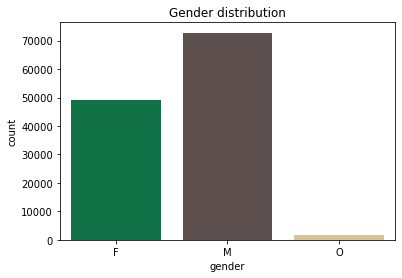

In [29]:
sns.set_palette(sns.color_palette(starbucks))

df = transactions[['gender', 'age', 'amount', 'income']]

ax = sns.countplot(x='gender', data=df)
ax.set_title('Gender distribution');

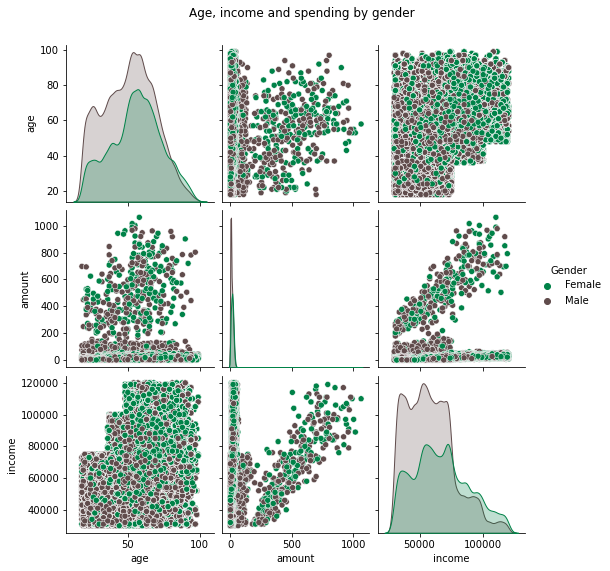

In [30]:
sns.set_palette(sns.color_palette(starbucks))

df = transactions[['gender', 'age', 'amount', 'income']].query('gender in ["F", "M"]')

df.rename(columns={'gender': 'Gender'}, inplace=True)
df['Gender'] = df['Gender'].map({'M': 'Male', 'F': 'Female'})

g = sns.pairplot(df, hue='Gender')
g.fig.suptitle("Age, income and spending by gender", y=1.05);

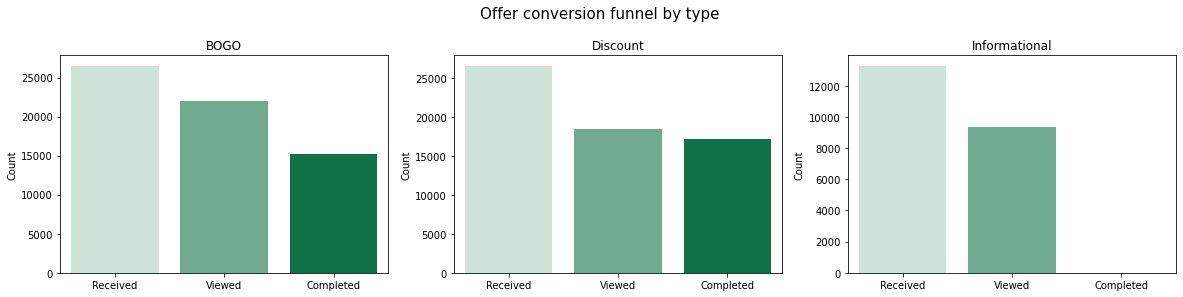

In [31]:
sns.set_palette(sns.color_palette(starbucks))

df = offers.groupby(['event', 'offer_type'])['person'].count().reset_index()
df['event'] = pd.Categorical(df['event'], ["offer received", "offer viewed", "offer completed"])
df.sort_values('event', inplace=True)

fig, axs = plt.subplots(ncols=3, figsize=(20, 4))

df['event'] = df['event'].map({'offer received': 'Received', 'offer viewed': 'Viewed', 'offer completed': 'Completed'})

ax = sns.barplot('event', y='person', data=df.query('offer_type == "bogo"'), palette=starbucks_d, ci=None, ax=axs[0])
ax.set(xlabel='', ylabel='Count', title='BOGO')

ax = sns.barplot('event', y='person', data=df.query('offer_type == "discount"'), palette=starbucks_d, ci=None, ax=axs[1])
ax.set(xlabel='', ylabel='Count', title='Discount')

ax = sns.barplot('event', y='person', data=df.query('offer_type == "informational"'), palette=starbucks_d, ci=None, ax=axs[2])
ax.set(xlabel='', ylabel='Count', title='Informational')

fig.suptitle('Offer conversion funnel by type', size=15, y=1.05);

## Modeling

### Feature scaling

In [138]:
scaler = StandardScaler().fit(customers)

customers_scaled = scaler.transform(customers)

### Dimensionality reduction

In [139]:
pca = PCA()
X_pca = pca.fit_transform(customers_scaled)

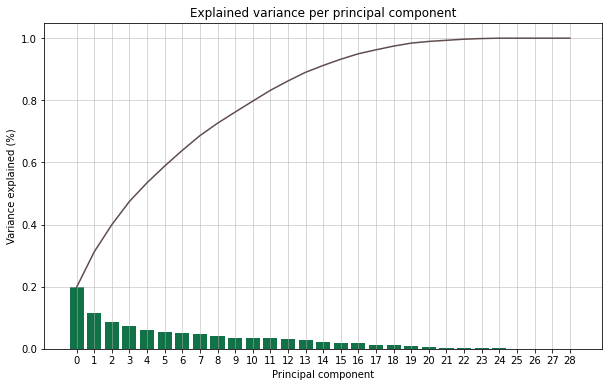

In [140]:
# Scree plot (variance explained by each principal component)
num_components=len(pca.explained_variance_ratio_)
ind = np.arange(num_components)
vals = pca.explained_variance_ratio_
cumvals = np.cumsum(vals)

plt.figure(figsize=(10,6))

ax = sns.barplot(ind, vals, palette=starbucks[:1], ci=None)
ax2 = sns.lineplot(ind, cumvals, color=starbucks[1], ci=None)
ax.grid(b=True, which='major', linewidth=0.5)

ax.set_xlabel("Principal component")
ax.set_ylabel("Variance explained (%)")
plt.title('Explained variance per principal component');

In [141]:
cum_expl_var_ratio = np.cumsum(pca.explained_variance_ratio_)
num_components = len(cum_expl_var_ratio[cum_expl_var_ratio <= 0.8])
print('Number of components: ', num_components)

# rerun PCA with components that explain 80% of the variance
pca = PCA(num_components).fit(customers_scaled)
X_pca = pca.transform(customers_scaled)
X_pca = pd.DataFrame(X_pca)

np.cumsum(pca.explained_variance_ratio_)

Number of components:  11


array([0.19816865, 0.31212516, 0.39967174, 0.47449703, 0.5345604 ,
       0.58836647, 0.63882715, 0.68617646, 0.72616917, 0.76209507,
       0.79734628])

## Factor Analysis

Prior to conducting factor analysis, we need to evaluate if the data is suitable for PCA. The KMO-test and Bartlett’s test of sphericity are used to test if factor analysis will be useful with the data. The KMO-test examines the strength of partial correlation amongst the variables. KMO values closer to 1 indicate the data is well suited for factor analysis. As seen below the overall MSA (Measure of Sampling Adequacy) is 0.9, which indicates the variables are well suited for PCA.


Assumptions:

- There are no outliers in data.
- Sample size should be greater than the factor.
- There should not be perfect multicollinearity.
- There should not be homoscedasticity between the variables.


### KMO Test

KMO is a measure of the adequacy of sampling “Kaiser-Meyer-Olkin" and checks if it is possible to factorize the main variables efficiently. The correlation matrix is always the starting point. The variables are more or less correlated, but the others can influence the correlation between the two variables. Hence, with KMO, the partial correlation is used to measure the relation between two variables by removing the effect of the remaining variables.

In [83]:
#KMO Test
#KMO is a measure of the adequacy of sampling “Kaiser-Meyer-Olkin" and checks 
#if it is possible to factorize the main variables efficiently.
#The correlation matrix is always the starting point. The variables are more or
#less correlated, but the others can influence the correlation between the two 
#variables. Hence, with KMO, the partial correlation is used to measure the 
#relation between two variables by removing the effect of the remaining variables.

def kmo(dataset_corr):
    
    import numpy as np
    import math as math
    import collections
    
    r"""
    
    Parameters
    ----------
    dataset_corr : ndarray
        Array containing dataset correlation
        
    Returns
    -------
    out : namedtuple
        The function outputs the test value (value), the test value per variable (per_variable)
       
        Ex:
        Out[30]: 
        KMO_Test_Results(value=0.798844102413, 
        per_variable=
        Q1     0.812160468405
        Q2     0.774161264483
        Q3     0.786819432663
        Q4     0.766251123086
        Q5     0.800579196084
        Q6     0.842927745203 
        Q7     0.792010173432 
        Q8     0.862037322891
        Q9     0.714795031915 
        Q10    0.856497242574
        dtype: float64)
    
    References
    ----------    
    [1] Kaiser, H. F. (1970). A second generation little jiffy. Psychometrika, 35(4), 401-415.
    [2] Kaiser, H. F. (1974). An index of factorial simplicity. Psychometrika, 39(1), 31-36.
    [3] R. Sarmento and V. Costa, (2017)
    "Comparative Approaches to Using R and Python for Statistical Data Analysis", IGI-Global
    
    Examples
    --------
    illustration how to use the function.
    
    >>> kmo_test(survey_data.corr(method="spearman"))
         
"""
    
    

    #KMO Test
    #inverse of the correlation matrix
    corr_inv = np.linalg.inv(dataset_corr)
    nrow_inv_corr, ncol_inv_corr = dataset_corr.shape
    
    #partial correlation matrix
    A = np.ones((nrow_inv_corr,ncol_inv_corr))
    for i in range(0,nrow_inv_corr,1):
        for j in range(i,ncol_inv_corr,1):
            #above the diagonal
            A[i,j] = - (corr_inv[i,j]) / (math.sqrt(corr_inv[i,i] * corr_inv[j,j]))
            #below the diagonal
            A[j,i] = A[i,j]
    
    #transform to an array of arrays ("matrix" with Python)
    dataset_corr = np.asarray(dataset_corr)
        
    #KMO value
    kmo_num = np.sum(np.square(dataset_corr)) - np.sum(np.square(np.diagonal(dataset_corr)))
    kmo_denom = kmo_num + np.sum(np.square(A)) - np.sum(np.square(np.diagonal(A)))
    kmo_value = kmo_num / kmo_denom
    
    
    kmo_j = [None]*dataset_corr.shape[1]
    #KMO per variable (diagonal of the spss anti-image matrix)
    for j in range(0, dataset_corr.shape[1]):
        kmo_j_num = np.sum(dataset_corr[:,[j]] ** 2) - dataset_corr[j,j] ** 2
        kmo_j_denom = kmo_j_num + np.sum(A[:,[j]] ** 2) - A[j,j] ** 2
        kmo_j[j] = kmo_j_num / kmo_j_denom

    Result = collections.namedtuple("KMO_Test_Results", ["value", "per_variable"])   

    #Output of the results - named tuple    
    return Result(value=kmo_value, per_variable=kmo_j)

In [84]:
kmo( customers.corr(method='spearman') )

KMO_Test_Results(value=0.46381844453555615, per_variable=[0.9124076973750371, 0.7088992045984358, 0.37110516332270105, 0.3734360447646911, 0.016199574650895287, 0.009235456047274614, 0.025047518997589478, 0.044049615787708704, 0.1008821892698476, 0.08670206651639424, 0.12735848100352226, 0.7244069147967618, 0.67848438816288, 0.8002692856478948, 0.6547939087664217, 0.5267609890758808, 0.8136060498889627, 0.8884900286221361, 0.8776423466851347, 0.9139545904155314, 0.6184418243958332, 0.5834630083631107, 0.5563624672808156, 0.8136060498889631, 0.7551928019779918, 0.7055633878984374, 0.4628067877488752, 0.4984402925685724, 0.6910917593522631])


### Bartlett Sphericity Test

Exploratory factor analysis is only useful if the matrix of population correlation is statistically different from the identity matrix. If these are equal, the variables are few interrelated, i.e., the specific factors explain the greater proportion of the variance and the common factors are unimportant. Therefore, it should be defined when the correlations between the original variables are sufficiently high. Thus, the factor analysis is useful in estimation of common factors. With this in mind, the Bartlett Sphericity test can be used. The hypotheses are:

H0: the matrix of population correlations is equal to the identity matrix

H1: the matrix of population correlations is different from the identity matrix.

In [85]:
#Bartlett Sphericity Test
#Exploratory factor analysis is only useful if the matrix of population 
#correlation is statistically different from the identity matrix. 
#If these are equal, the variables are few interrelated, i.e., the specific 
#factors explain the greater proportion of the variance and the common factors
#are unimportant. Therefore, it should be defined when the correlations 
#between the original variables are sufficiently high. 
#Thus, the factor analysis is useful in estimation of common factors. 
#With this in mind, the Bartlett Sphericity test can be used. The hypotheses are:

# H0: the matrix of population correlations is equal to the identity matrix
# H1: the matrix of population correlations is different from the identity matrix.

def bartlett_sphericity(dataset, corr_method="pearson"):
    
    r"""
    
    Parameters
    ----------
    dataset : dataframe, mandatory (numerical or ordinal variables)
        
    corr_method : {'pearson', 'spearman'}, optional
        
    Returns
    -------
    out : namedtuple
        The function outputs the test value (chi2), the degrees of freedom (ddl)
        and the p-value.
        It also delivers the n_p_ratio if the number of instances (n) divided 
        by the numbers of variables (p) is more than 5. A warning might be issued.
        
        Ex:
        chi2:  410.27280642443156
        ddl:  45.0
        p-value:  8.73359410503e-61
        n_p_ratio:    20.00
        
        Out: Bartlett_Sphericity_Test_Results(chi2=410.27280642443156, ddl=45.0, pvalue=8.7335941050291506e-61)
    
    References
    ----------
    
    [1] Bartlett,  M.  S.,  (1951),  The  Effect  of  Standardization  on  a  chi  square  Approximation  in  Factor
    Analysis, Biometrika, 38, 337-344.
    [2] R. Sarmento and V. Costa, (2017)
    "Comparative Approaches to Using R and Python for Statistical Data Analysis", IGI-Global.
    
    Examples
    --------
    illustration how to use the function.
    
    >>> bartlett_sphericity(survey_data, corr_method="spearman")
    chi2:  410.27280642443145
    ddl:  45.0
    p-value:  8.73359410503e-61
    n_p_ratio:    20.00
    C:\Users\Rui Sarmento\Anaconda3\lib\site-packages\spyderlib\widgets\externalshell\start_ipython_kernel.py:75: 
    UserWarning: NOTE: we advise  to  use  this  test  only  if  the number of instances (n) divided by the number of variables (p) is lower than 5. Please try the KMO test, for example.
    backend_o = CONF.get('ipython_console', 'pylab/backend', 0)
    Out[12]: Bartlett_Sphericity_Test_Results(chi2=410.27280642443156, ddl=45.0, pvalue=8.7335941050291506e-61)
    """
    
    import numpy as np
    import math as math
    import scipy.stats as stats
    import warnings as warnings
    import collections

    #Dimensions of the Dataset
    n = dataset.shape[0]
    p = dataset.shape[1]
    n_p_ratio = n / p
    
    # Several Calculations
    chi2 = - (n - 1 - (2 * p + 5) / 6) * math.log(np.linalg.det(dataset.corr(method=corr_method)))
    # Freedom Degree
    ddl = p * (p - 1) / 2
    # p-value
    pvalue = 1 - stats.chi2.cdf(chi2 , ddl)
    

    df = pd.DataFrame([])
    df['chi2']      = [chi2]
    df['ddl']       = [ddl]
    df['p-value']   = [pvalue]
    df['n_p_ratio'] = [n_p_ratio]
    
    
    # Output of the function
    #
    if n_p_ratio > 5 :
        print("n_p_ratio: {0:8.2f}".format(n_p_ratio))
        warnings.warn("NOTE: we advise  to  use  this  test  only  if  the number of instances (n) divided by the number of variables (p) is lower than 5. Please try the KMO test, for example.")
    
    return( df )

In [86]:
print('Bartlett_Sphericity_Test_Results')
bartlett_sphericity(customers, corr_method="spearman")

Bartlett_Sphericity_Test_Results
n_p_ratio:   496.17


c:\Users\poseidon\anaconda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:93: UserWarning: NOTE: we advise  to  use  this  test  only  if  the number of instances (n) divided by the number of variables (p) is lower than 5. Please try the KMO test, for example.


,chi2,ddl,p-value,n_p_ratio
0,1.842696e+06,406.0,0.0,496.172414


In [92]:
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
# chi_square_value,p_value=calculate_bartlett_sphericity(df)
calculate_bartlett_sphericity( customers )

c:\Users\poseidon\anaconda\envs\tensorflow\lib\site-packages\factor_analyzer\factor_analyzer.py:118: RuntimeWarning: invalid value encountered in log
  statistic = -np.log(corr_det) * (n - 1 - (2 * p + 5) / 6)


(nan, nan)

### Factor analysis

In [101]:
from factor_analyzer import FactorAnalyzer
fa = FactorAnalyzer()

fa.set_params(n_factors=15, rotation=None)

fa.fit(customers )
# Check Eigenvalues
ev, v = fa.get_eigenvalues()
ev

array([ 5.74689096e+00,  3.30473857e+00,  2.53885098e+00,  2.16993343e+00,
        1.74183772e+00,  1.56037596e+00,  1.46335960e+00,  1.37313005e+00,
        1.15978862e+00,  1.04185107e+00,  1.02228530e+00,  1.00656978e+00,
        8.76397831e-01,  8.09042039e-01,  6.38864235e-01,  5.81862663e-01,
        5.11117453e-01,  3.68045876e-01,  3.44497436e-01,  2.80134832e-01,
        1.57478501e-01,  1.05115804e-01,  1.01503922e-01,  6.15609257e-02,
        3.47664506e-02,  1.25223594e-16, -6.62531361e-16, -7.86811747e-16,
       -1.39494094e-15])

### Determine the number of factors

Eigenvalues are nothing but the amount of variance the factor explains. We will select the number of factors whose eigenvalues are greater than 1.

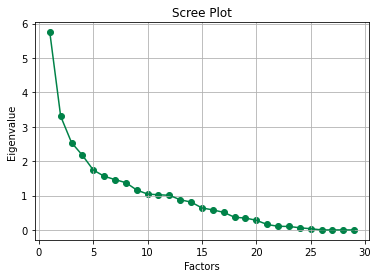

In [130]:
# Create scree plot using matplotlib
plt.scatter(range(1,customers.shape[1]+1), ev)
plt.plot(range(1,customers.shape[1]+1),ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

## Performing Factor Analysis

In [132]:
# Create factor analysis object and perform factor analysis
fa = FactorAnalyzer()

fa.set_params(n_factors=10, rotation='varimax')

fa.fit( customers )


FactorAnalyzer(n_factors=10, rotation='varimax', rotation_kwargs={})

### INTERPRETING THE FACTORS

In [136]:
factor_df=pd.DataFrame(fa.loadings_, index=customers.columns)
print(factor_df)

                                0         1         2         3         4  \
age                     -0.026868 -0.028720  0.082623  0.002331 -0.174185   
income                  -0.072792 -0.052118  0.097409 -0.006337 -0.280131   
gender_F                -0.045569 -0.016054  0.945137  0.004869 -0.096558   
gender_M                 0.042536  0.016322 -0.980542 -0.009031  0.089973   
gender_O                 0.009019 -0.001288  0.021670  0.014663  0.015107   
year_joined_2013         0.004886 -0.004016 -0.021241 -0.011777  0.101635   
year_joined_2014         0.016352  0.006870 -0.063974 -0.012933  0.164927   
year_joined_2015        -0.032942 -0.000411  0.001006  0.011828  0.078146   
year_joined_2016        -0.035019 -0.015589  0.066562  0.046008  0.116674   
year_joined_2017         0.004914 -0.003654  0.012180 -0.004497 -0.161201   
year_joined_2018         0.054041  0.022371 -0.040079 -0.018934 -0.200364   
frequency                0.045208  0.028219  0.049846  0.118121  0.889767   

#### VARIANCE

The amount of variance explained by each factor can be found out using the ‘get_factor_variance’ function.

In [142]:
print(pd.DataFrame(fa.get_factor_variance(),index=['Variance','Proportional Var','Cumulative Var']))

                         0         1         2         3         4         5  \
Variance          5.398286  2.216001  1.910037  1.793189  1.787730  1.708074   
Proportional Var  0.186148  0.076414  0.065863  0.061834  0.061646  0.058899   
Cumulative Var    0.186148  0.262562  0.328425  0.390259  0.451905  0.510804   

                         6         7         8         9  
Variance          1.706625  1.329242  1.166088  1.123918  
Proportional Var  0.058849  0.045836  0.040210  0.038756  
Cumulative Var    0.569653  0.615489  0.655699  0.694455  


In [143]:
# Variance Explained by Factors (Image by Author)

# The first row represents the variance explained by each factor. 
# Proportional variance is the variance explained by a factor out of the total variance. 
# Cumulative variance is nothing but the cumulative sum of proportional variances of each factor. 
# 
# 
# 
# In our case, the 6 factors together are able to explain 69.4% of the total variance.